In [ ]:
# https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 4.1 MB/s 
     |████████████████████████████████| 636 kB 62.3 MB/s 
     |████████████████████████████████| 3.3 MB 15.9 MB/s 
     |████████████████████████████████| 895 kB 78.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install pytorch-lightning

     |████████████████████████████████| 915 kB 4.0 MB/s 
     |████████████████████████████████| 118 kB 13.1 MB/s 
     |████████████████████████████████| 234 kB 12.6 MB/s 
     |████████████████████████████████| 829 kB 12.4 MB/s 
     |████████████████████████████████| 10.6 MB 138 kB/s 
     |████████████████████████████████| 1.3 MB 47.5 MB/s 
     |████████████████████████████████| 294 kB 44.6 MB/s 
     |████████████████████████████████| 142 kB 47.1 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=382c0096c18ad8b6140436acabba90c80fb14dee05275726d728a0c8e0412b35
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Attempting uninstall: future
    Found existing installation: future 0.16.0
  

In [ ]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline  
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

In [ ]:
# import dataset
df = pd.read_csv('/content/drive/MyDrive/Biocreative/Biocreative/litcovid_dataset.csv')
df.head()

,pmid,journal,title,abstract,keywords,pub_type,authors,doi,label,Case Report,Diagnosis,Epidemic Forecasting,Mechanism,Prevention,Transmission,Treatment
0,32519164,J Thromb Thrombolysis,Potential role for tissue factor in the pathog...,"In December 2019, a new and highly contagious ...",covid-19;il-6;sars-cov-2;tnf-alpha;thrombosis;...,Journal Article;Review,"Bautista-Vargas, Mario;Bonilla-Abadia, Fabio;C...",10.1007/s11239-020-02172-x,Treatment;Mechanism,0,0,0,1,0,0,1
1,32691006,J Tradit Complement Med,Dietary therapy and herbal medicine for COVID-...,"A novel coronavirus disease (COVID-19), transm...",covid-19;coronavirus;dietary therapy;herbal me...,Journal Article;Review,"Panyod, Suraphan;Ho, Chi-Tang;Sheen, Lee-Yan",10.1016/j.jtcme.2020.05.004,Treatment;Prevention,0,0,0,0,1,0,1
2,32858315,J Affect Disord,First report of manic-like symptoms in a COVID...,"BACKGROUND: In December 2019, the novel corona...",cerebrospinal fluid;igg;manic-like symptoms;sa...,Case Reports;Journal Article,"Lu, Shaojia;Wei, Ning;Jiang, Jiajun;Wu, Lingli...",10.1016/j.jad.2020.08.031,Case Report,1,0,0,0,0,0,0
3,32985329,J Dent Res,Epidemiological Investigation of OHCWs with CO...,During the coronavirus disease 2019 (COVID-19)...,dental education;dental public health;infectio...,"Journal Article;Research Support, Non-U.S. Gov't","Meng, L;Ma, B;Cheng, Y;Bian, Z",10.1177/0022034520962087,Prevention,0,0,0,0,1,0,0
4,32812051,J Antimicrob Chemother,The impact of sofosbuvir/daclatasvir or ribavi...,OBJECTIVES: Sofosbuvir and daclatasvir are dir...,NaN,Journal Article;Randomized Controlled Trial;Re...,"Eslami, Gholamali;Mousaviasl, Sajedeh;Radmanes...",10.1093/jac/dkaa331,Treatment,0,0,0,0,0,0,1


In [ ]:
# preprocess dataset
df = df.drop(['pmid',	'journal',	'title', 'doi',	'label', 'keywords', 'pub_type', 'authors'], axis=1)
df.head()

,abstract,Case Report,Diagnosis,Epidemic Forecasting,Mechanism,Prevention,Transmission,Treatment
0,"In December 2019, a new and highly contagious ...",0,0,0,1,0,0,1
1,"A novel coronavirus disease (COVID-19), transm...",0,0,0,0,1,0,1
2,"BACKGROUND: In December 2019, the novel corona...",1,0,0,0,0,0,0
3,During the coronavirus disease 2019 (COVID-19)...,0,0,0,0,1,0,0
4,OBJECTIVES: Sofosbuvir and daclatasvir are dir...,0,0,0,0,0,0,1


In [ ]:
train_df, val_df = train_test_split(df, test_size=0.1)
train_df.shape, val_df.shape

((22464, 8), (2496, 8))

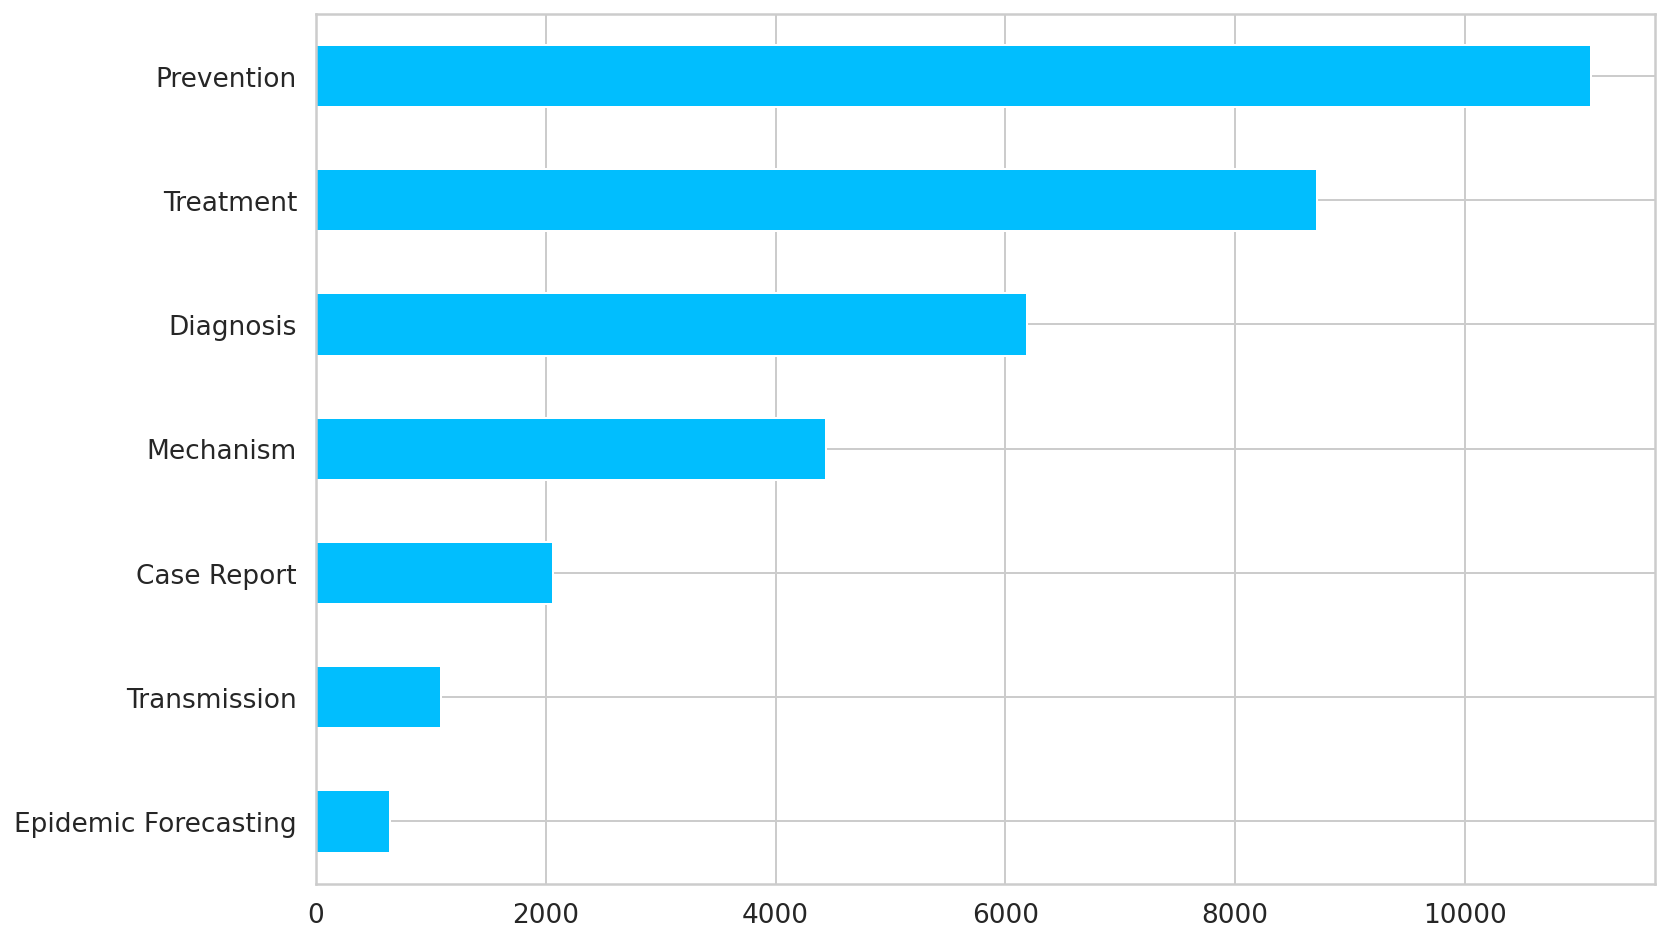

In [ ]:
LABEL_COLUMNS = df.columns.tolist()[1:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

In [ ]:
print(LABEL_COLUMNS)

['Case Report', 'Diagnosis', 'Epidemic Forecasting', 'Mechanism', 'Prevention', 'Transmission', 'Treatment']


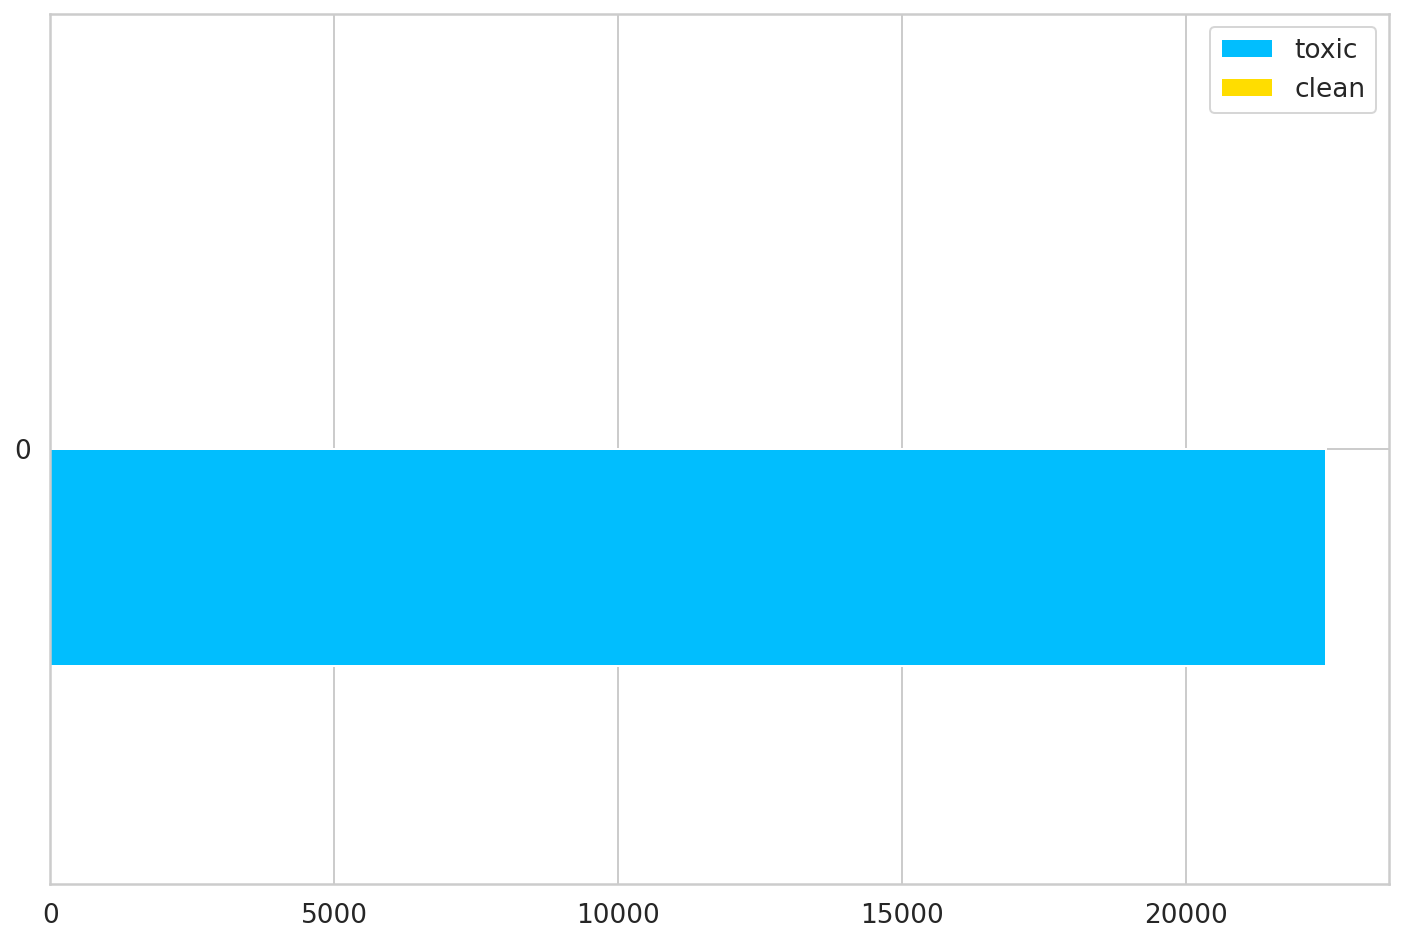

In [ ]:
annotated = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
non_annotated = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  annotated=[len(annotated)],
  non_annotated=[len(non_annotated)]
)).plot(kind='barh');

In [ ]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

(0.0, 512.0)

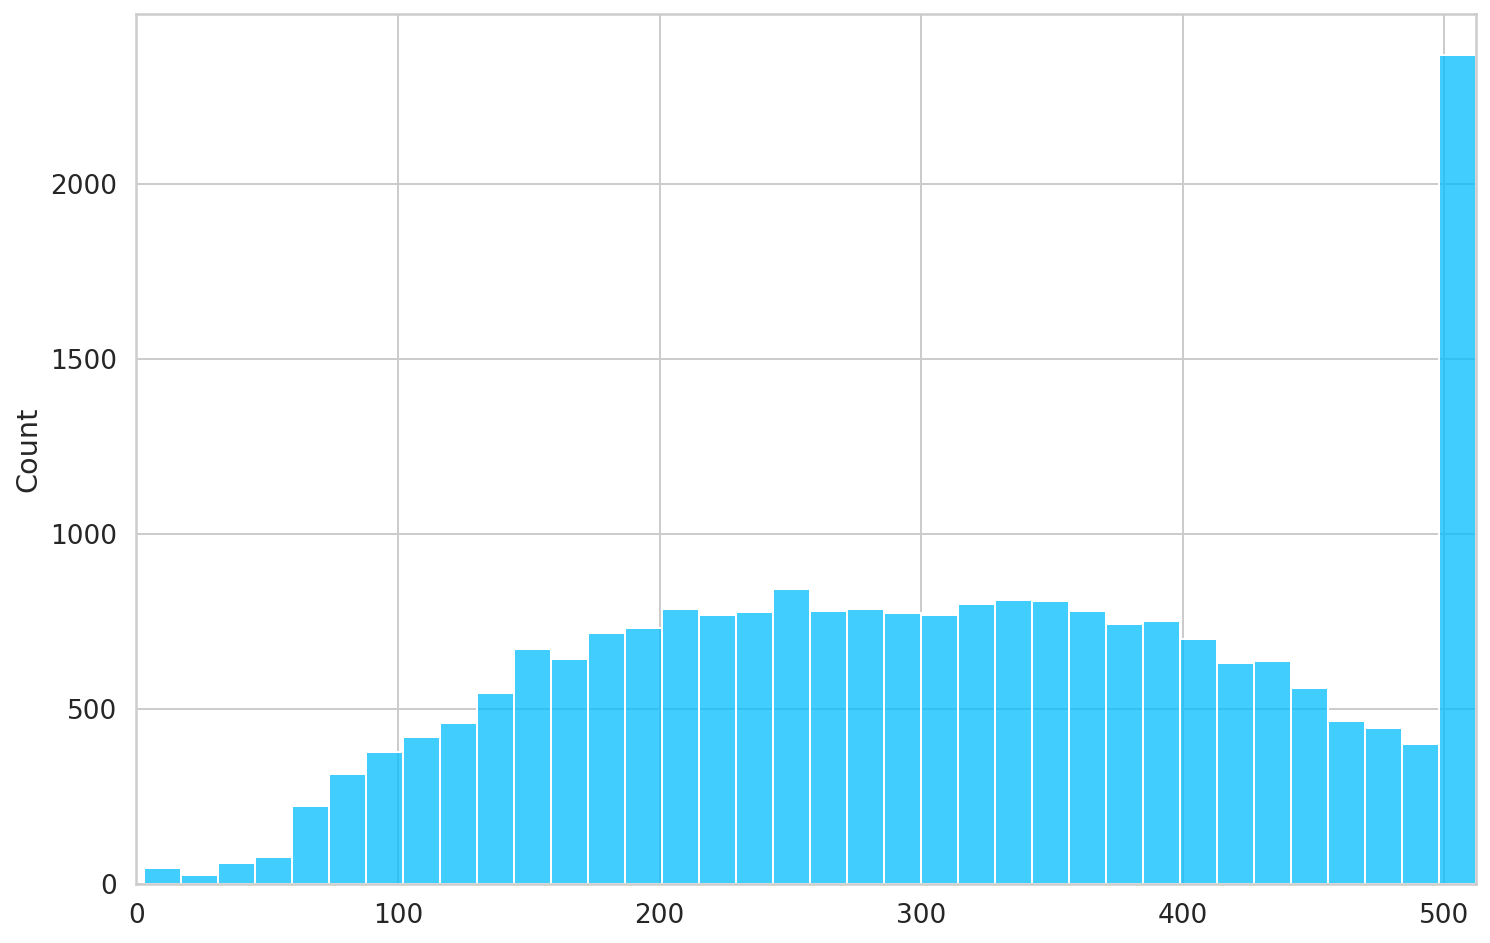

In [ ]:
token_counts = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
      row["abstract"],
      max_length=512,
      truncation=True
  ))

  token_counts.append(token_count)

sns.histplot(token_counts)
plt.xlim([0, 512])

(0.0, 8284.0)

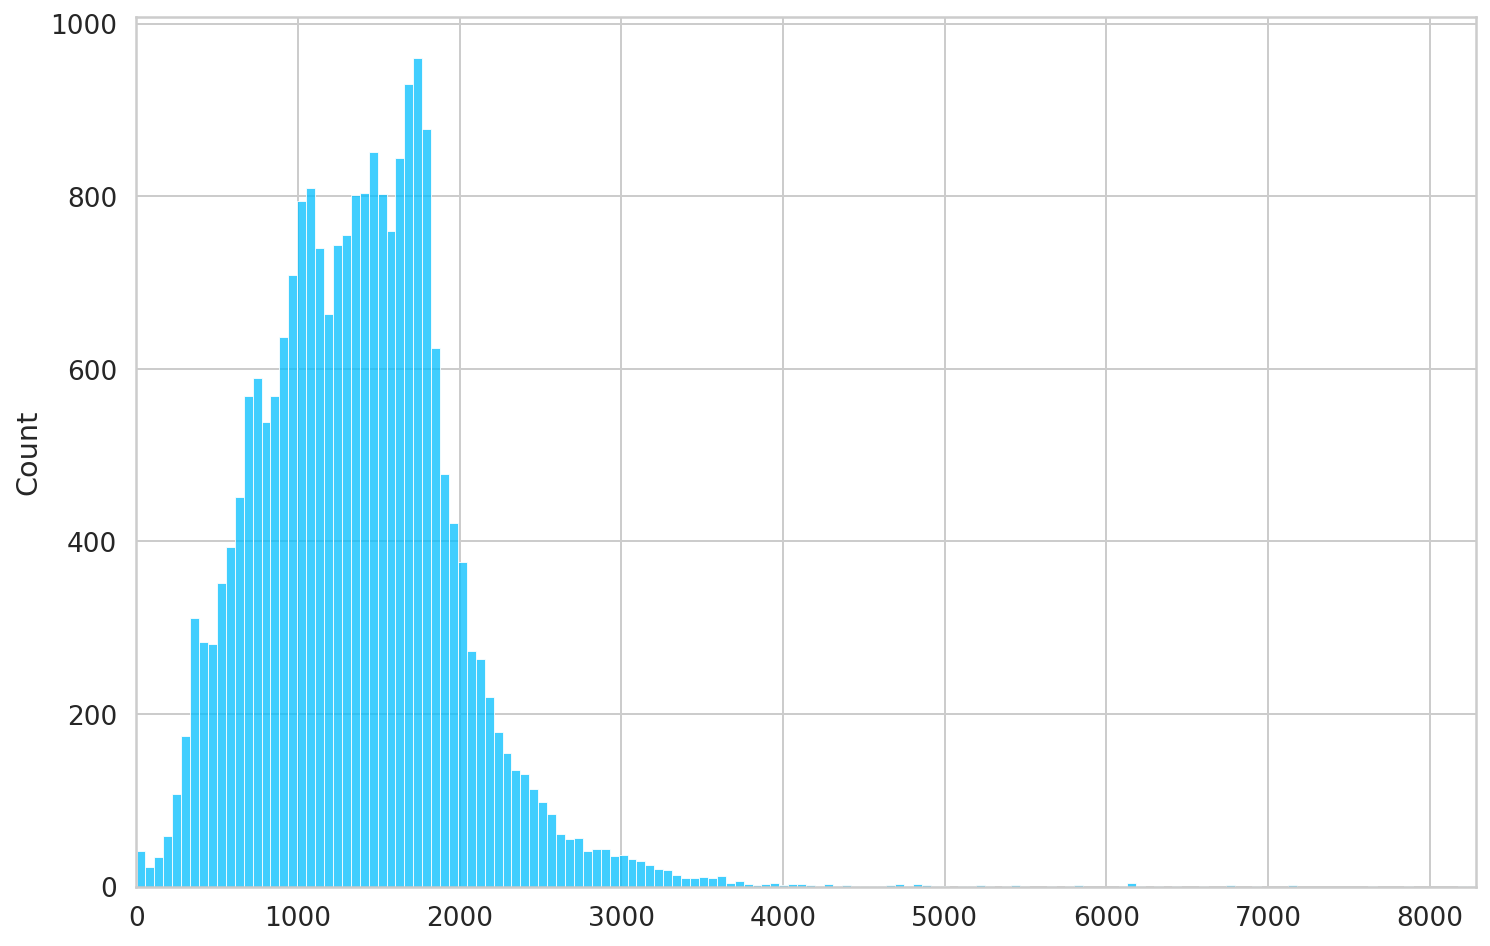

In [ ]:
char_lengths = []

for _, row in train_df.iterrows():
  char_lengths.append(len(row["abstract"]))

sns.histplot(char_lengths)
plt.xlim([0, max(char_lengths)])

(0.0, 1267.0)

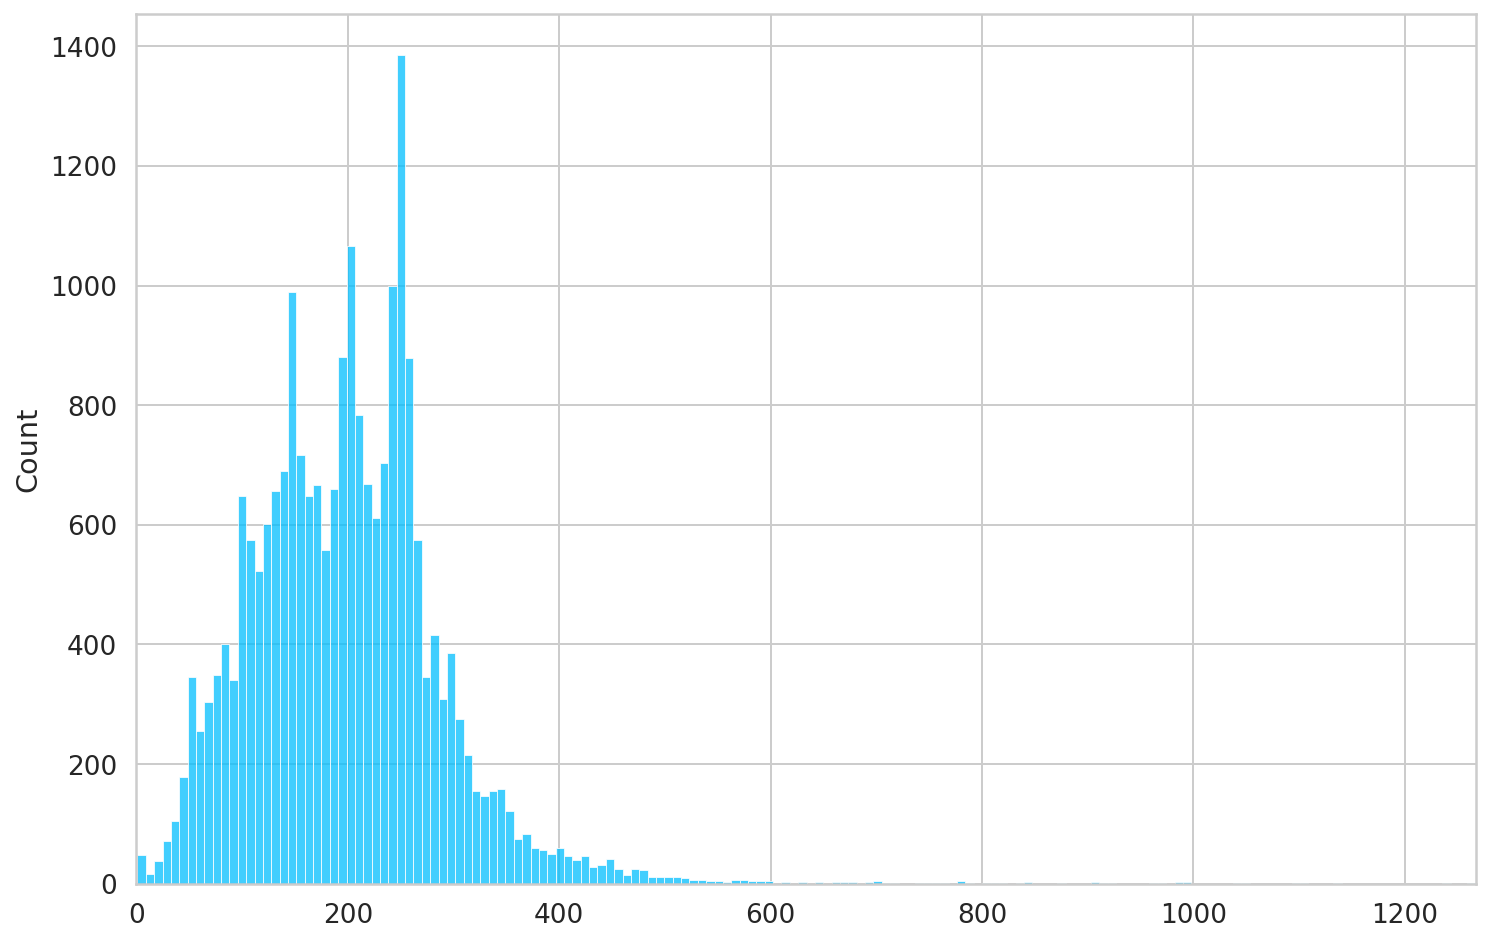

In [ ]:
word_lengths = []

for _, row in train_df.iterrows():
  word_lengths.append(len(row["abstract"].split(' ')))

sns.histplot(word_lengths)
plt.xlim([0, max(word_lengths)])

In [ ]:
MAX_TOKEN_COUNT = 512

In [ ]:
class TopicAnnotationDataset(Dataset):

  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: BertTokenizer,
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index=int):
    
    data_row = self.data.iloc[index]

    abstract_text = data_row.abstract
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
        abstract_text,
        add_special_tokens=True,
        max_length=self.max_token_len,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    return dict(
        abstract_text=abstract_text,
        input_ids=encoding["input_ids"].flatten(),
        attention_mask=encoding["attention_mask"].flatten(),
        labels=torch.FloatTensor(labels) 
    )  

In [ ]:
train_dataset = TopicAnnotationDataset(
    train_df,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

### cells to avoid during final run.

In [ ]:
# instantiating a bert model
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME)

sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch.keys()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


dict_keys(['abstract_text', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

In [ ]:
# output dimensions from bert model
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([8, 512, 768]), torch.Size([8, 768]))

In [ ]:
# size of last hidden layer.
bert_model.config.hidden_size

768

### continutation

In [ ]:
class TopicAnnotationDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    
    self.train_dataset =  TopicAnnotationDataset(
        self.train_df,
        self.tokenizer,
        self.max_token_len
    )

    self.test_dataset = TopicAnnotationDataset(
        self.test_df,
        self.tokenizer,
        self.max_token_len
    )

  def train_dataloader(self):

    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):

    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 4

data_module = TopicAnnotationDataModule(
    train_df,
    val_df,
    tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
class TopicAnnotationTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):

    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]

    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):

    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)

  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
        optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

### optimizer scheduler
- dummy model 

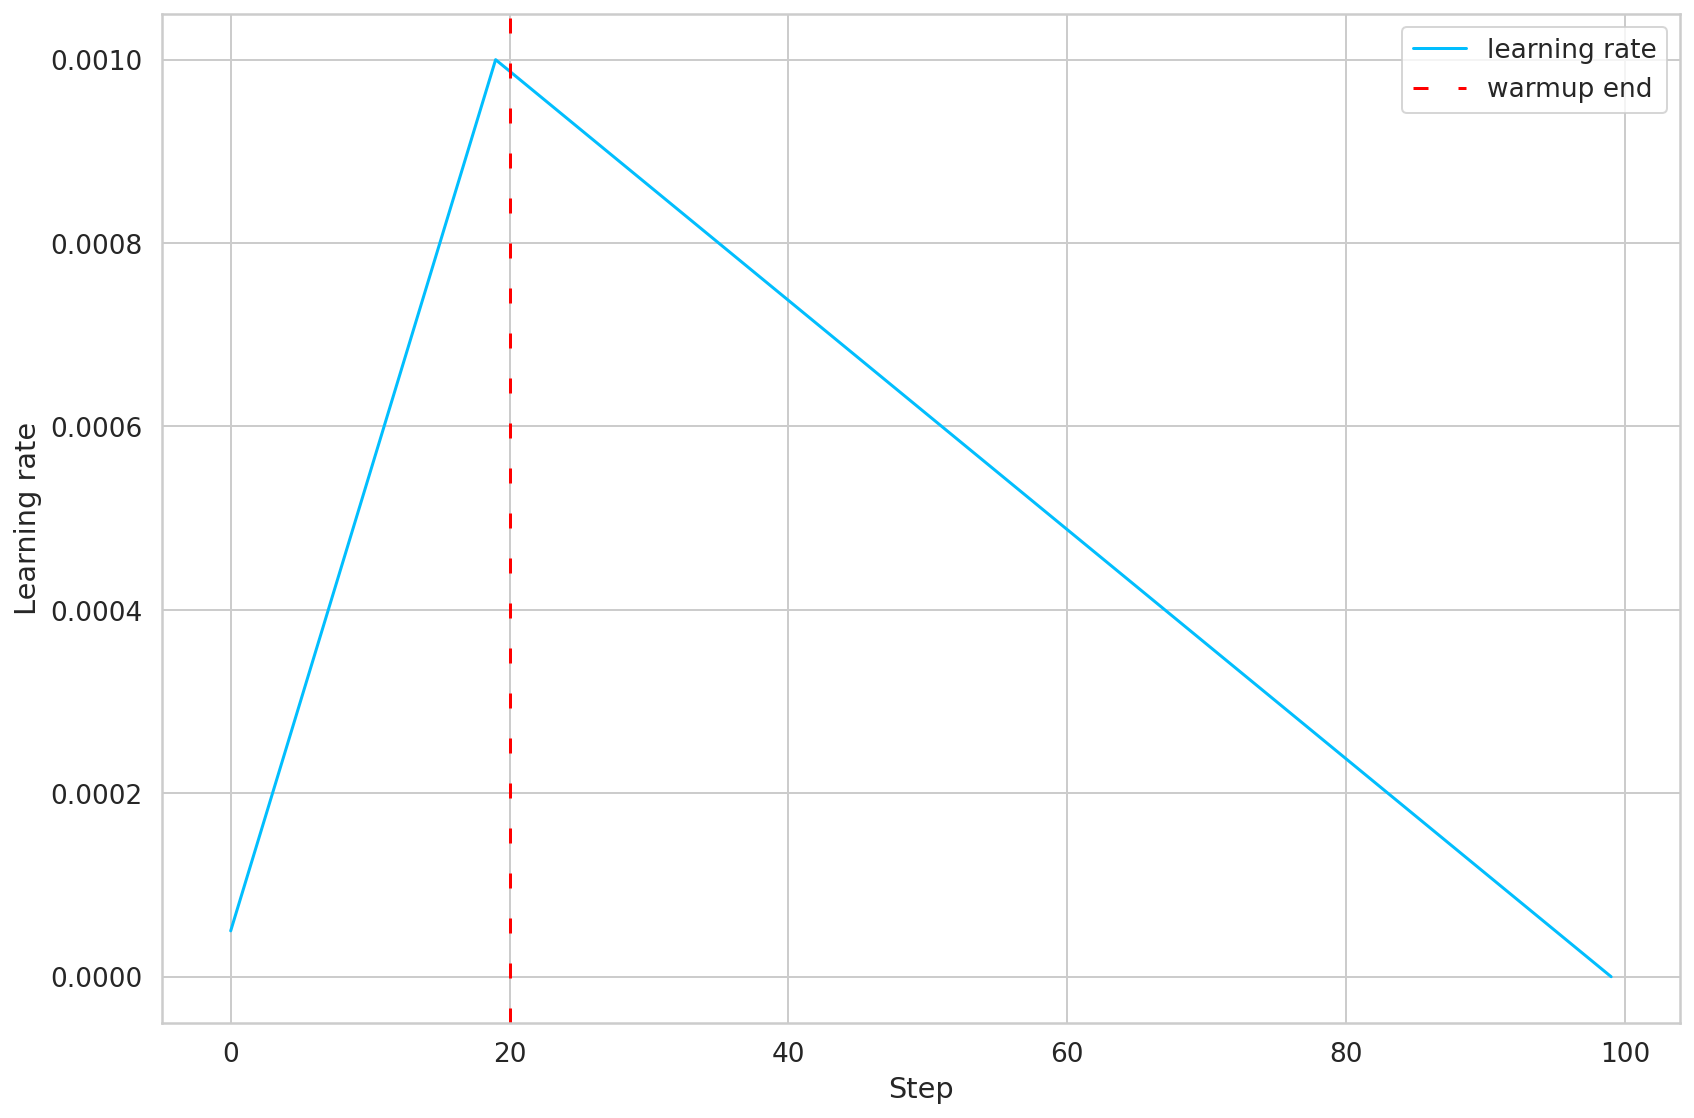

In [ ]:
dummy_model = nn.Linear(2, 1)

optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)

warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):

  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])

plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

### continuation

In [ ]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(11232, 56160)

In [ ]:
model = TopicAnnotationTagger(
    n_classes=len(LABEL_COLUMNS),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Evaluation

In [ ]:
criterion = nn.BCELoss()
prediction = torch.FloatTensor(
    [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)

labels = torch.FloatTensor(
    [1., 0., 0., 0., 1., 0.]
)

torch.sigmoid(prediction)

tensor([1.0000, 0.7452, 0.8299, 0.5096, 1.0000, 0.7493])

In [ ]:
criterion(torch.sigmoid(prediction), labels)

tensor(0.8725)

In [ ]:
# same approach as above can be applied to the model
_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
predictions

tensor([[0.5482, 0.5086, 0.3149, 0.3649, 0.4308, 0.5490, 0.4492],
        [0.4947, 0.5273, 0.4164, 0.3910, 0.3953, 0.5708, 0.4941],
        [0.5665, 0.5100, 0.3335, 0.3716, 0.4414, 0.5355, 0.4089],
        [0.5438, 0.5232, 0.3092, 0.3729, 0.4299, 0.5572, 0.4375],
        [0.5496, 0.5269, 0.3175, 0.3602, 0.4343, 0.5449, 0.4427],
        [0.5530, 0.5127, 0.3081, 0.3693, 0.4319, 0.5485, 0.4441],
        [0.5334, 0.5166, 0.3122, 0.3651, 0.4315, 0.5499, 0.4579],
        [0.4838, 0.5611, 0.4841, 0.4175, 0.4116, 0.5799, 0.4936]],
       grad_fn=<SigmoidBackward>)

In [ ]:
criterion(torch.sigmoid(predictions), sample_batch["labels"])

tensor(0.8342, grad_fn=<BinaryCrossEntropyBackward>)

### ROC Curve

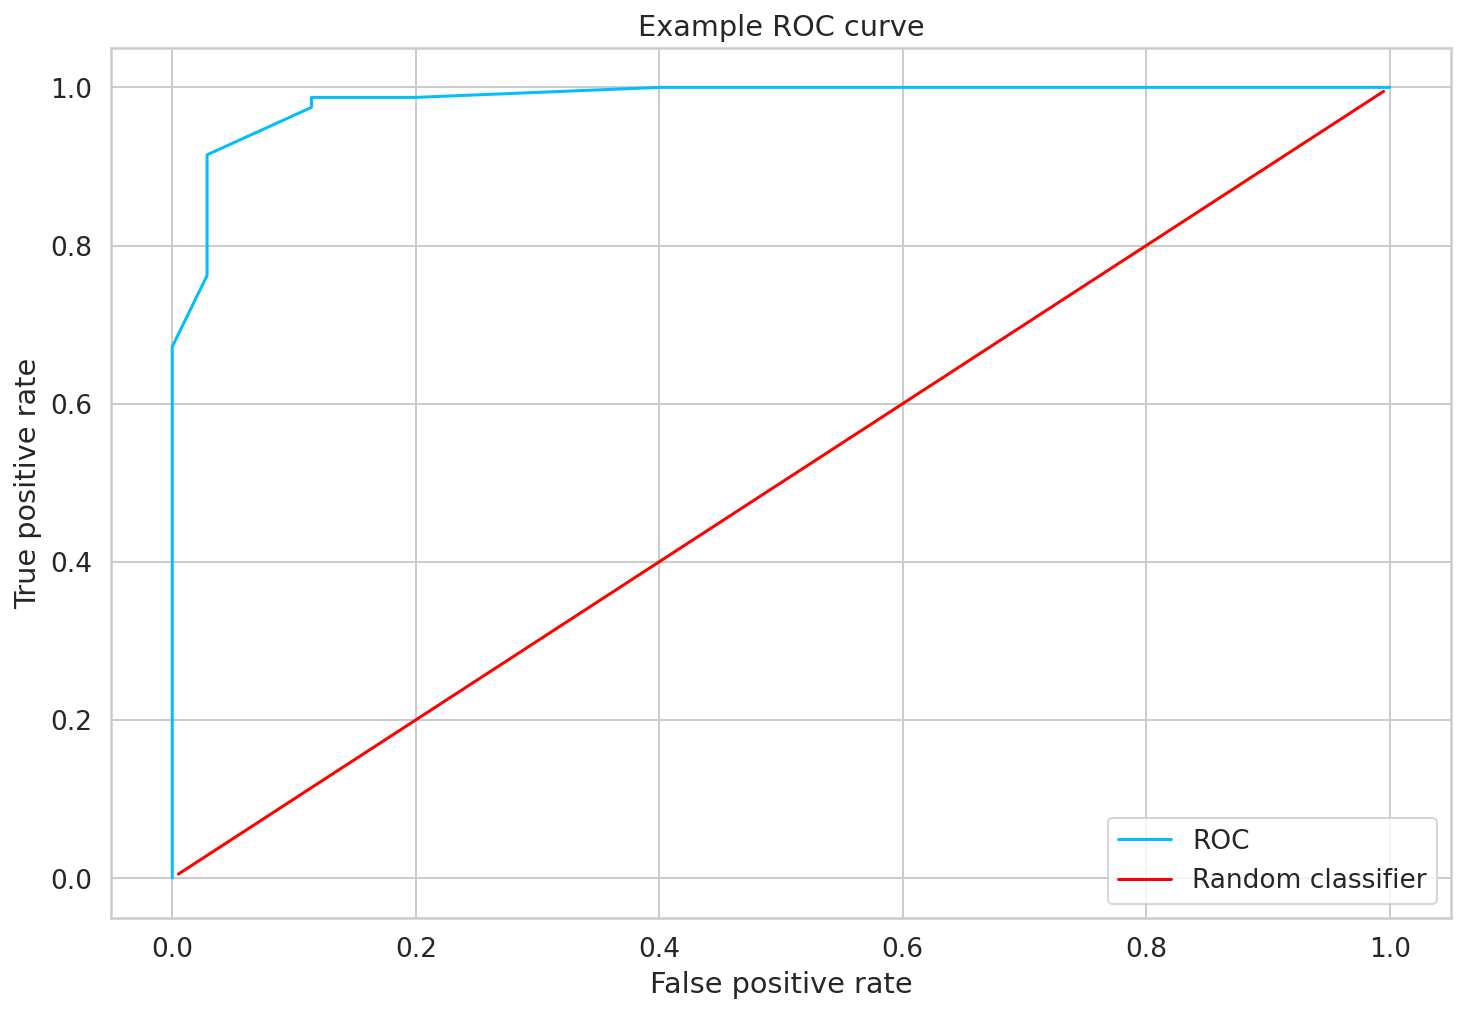

In [ ]:
from sklearn import metrics

fpr = [0.        , 0.        , 0.        , 0.02857143, 0.02857143,
       0.11428571, 0.11428571, 0.2       , 0.4       , 1.        ]
tpr = [0.        , 0.01265823, 0.67202532, 0.76202532, 0.91468354,
       0.97468354, 0.98734177, 0.98734177, 1.        , 1.        ]

_, ax = plt.subplots()
ax.plot(fpr, tpr, label="ROC")
ax.plot([0.05, 0.95], [0.05, 0.95], transform=ax.transAxes, label="Random classifier", color="red")
ax.legend(loc=4)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Example ROC curve")
plt.show();

### continuation

In [ ]:
%pwd

'/content'

In [ ]:
cd '/content/drive/MyDrive/Biocreative/Biocreative'

/content/drive/MyDrive/Biocreative/Biocreative


In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="topic-annotations")

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=True,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 5.4 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.263   Total estimated model params size (MB)


Global seed set to 42


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:398: LightningDeprecationWarning: One of the returned values {'predictions', 'labels'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `auroc` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.auroc.auroc`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)
Epoch 0, global step 5615: val_loss reached 0.15464 (best 0.15464), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/checkpoints/best-checkpoint.ckpt" as top 1


Epoch 1, global step 11231: val_loss reached 0.15291 (best 0.15291), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/checkpoints/best-checkpoint.ckpt" as top 1


### New Section

In [ ]:
pwd

'/content'

In [ ]:
cd drive/MyDrive/Biocreative/Biocreative/Models/

/content/drive/MyDrive/Biocreative/Biocreative/Models


In [ ]:
!nvidia-smi

Sat Aug  7 06:47:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 6.2 MB/s 
     |████████████████████████████████| 636 kB 51.5 MB/s 
     |████████████████████████████████| 895 kB 69.0 MB/s 
     |████████████████████████████████| 3.3 MB 23.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install pytorch-lightning

     |████████████████████████████████| 915 kB 5.1 MB/s 
     |████████████████████████████████| 118 kB 59.4 MB/s 
     |████████████████████████████████| 234 kB 63.4 MB/s 
     |████████████████████████████████| 829 kB 38.4 MB/s 
     |████████████████████████████████| 5.6 MB 33.4 MB/s 
     |████████████████████████████████| 1.3 MB 43.5 MB/s 
     |████████████████████████████████| 294 kB 59.6 MB/s 
     |████████████████████████████████| 142 kB 71.6 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=375df127e98f804203261c29bb6fe4dec13a9475751b11d4ba2f9f0b2b6acfb1
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Attempting uninstall: future
    Found existing installation: future 0.16.0
  

In [ ]:
!pip install PyYaml

In [ ]:
!pip install munch

In [ ]:
cd drive/MyDrive/Biocreative/Biocreative/Models/

/content/drive/MyDrive/Biocreative/Biocreative/Models


In [ ]:
!python main.py --no_cuda

2021-08-07 10:56:53.166215: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
cpu
0
Downloading: 100% 213k/213k [00:00<00:00, 5.43MB/s]
Downloading: 100% 436k/436k [00:00<00:00, 8.30MB/s]
Downloading: 100% 29.0/29.0 [00:00<00:00, 22.1kB/s]
Downloading: 100% 570/570 [00:00<00:00, 448kB/s]
Downloading: 100% 436M/436M [00:08<00:00, 51.8MB/s]
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a 